### DataPreprocessing

In [6]:
import pandas as pd
from imblearn.over_sampling import SMOTE

import numpy as np
import matplotlib.pyplot as plt
import os
import random
import torch
import torch.nn as nn
import scipy

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.pretraining import TabNetPretrainer

import optuna
from optuna import Trial
from optuna.samplers import TPESampler

import warnings

In [ ]:
data = pd.read_csv("CGAN.csv")

In [8]:
regions = ["서울","경기","대전","광주","대구","부산","인천","울산","강원",
           "충남","충북","전남","전북","경남","경북","제주"]

def read_split_data(data):
    X = {}
    y = {}
    
    # Train/Test 분할
    X['train'], X['test'], y['train'], y['test'] = train_test_split(
        data.iloc[:, :-1], data.iloc[:, -1], test_size=0.10, random_state=21
    )
    
    # train 데이터와 PM25_future 합치기
    temp = X['train'].copy()
    temp['PM25_future'] = y['train'].copy()
    
    demand = 8500 // len(regions)
    resampled_list = []

    for region in regions:
        subset = temp[temp['region'] == region].copy()

        X_region = subset.drop(columns=['region'])
        y_region = X_region['PM25_future'].apply(lambda x: 1 if x >= 36 else 0)
        
        minority_count = y_region.sum()

        if minority_count < 2:
            print(f"[SKIP] Region '{region}' has too few y=1 samples ({minority_count})")
            continue

        target_minority_total = minority_count + demand
        sm = SMOTE(
            sampling_strategy={1: target_minority_total},
            random_state=321,
            k_neighbors=min(minority_count - 1, 5)
        )

        X_res, y_res = sm.fit_resample(X_region, y_region)

        # 생성된 샘플 수만큼 slicing → 새로 생성된 synthetic sample만 추출
        n_generated = target_minority_total - minority_count
        X_synthetic = X_res.iloc[-n_generated:].copy()
        X_synthetic.loc[:, 'region'] = region  # ⚠️ .loc 사용으로 warning 방지

        resampled_list.append(X_synthetic)

    # 최종 SMOTE 데이터프레임
    final_df = pd.concat(resampled_list, ignore_index=True)

    # X, y 분리
    X_smote = final_df.drop(columns=["PM25_future"])
    y_smote = final_df["PM25_future"]

    # Validation 세트 분리
    X['train'], X['val'], y['train'], y['val'] = train_test_split(
        X['train'], y['train'], test_size=0.10, random_state=21
    )
    
    # 기존 학습 데이터에 증강된 데이터 추가
    X['train'] = pd.concat([X['train'], X_smote], ignore_index=True)
    y['train'] = pd.concat([y['train'], y_smote], ignore_index=True)
    
    return X, y

In [9]:
from imblearn.over_sampling import SMOTE 

def preprocessing(X,y):
    cat_index = X['train'].select_dtypes(['object']).columns
    num_index = X['train'].select_dtypes(['float64']).columns
    print(len(cat_index))
    print(len(num_index))
    cat_cardinalities = []
    column_order = {col: idx for idx,col in enumerate(X['train'].columns)}
    cat_column_index = [column_order[col] for col in cat_index]

    # StandardScaler

    ss = StandardScaler()
    X['train'][num_index] = ss.fit_transform(X['train'][num_index])
    X['val'][num_index] = ss.transform(X['val'][num_index])
    X['test'][num_index] = ss.transform(X['test'][num_index])

    # Label Encoder
    for col in cat_index:
        le = LabelEncoder()
        X['train'][col] = le.fit_transform(X['train'][col])
        X['val'][col] = le.transform(X['val'][col])
        X['test'][col] = le.transform(X['test'][col])
    
        max_cat = np.max([
                        np.max(X['train'][col]),
                        np.max(X['val'][col]),
                        np.max(X['test'][col])]) + 1
        cat_cardinalities.append(max_cat)
    return X, y, cat_cardinalities, cat_column_index

In [10]:
X, y = read_split_data(data)
X,y, cat_cardinalities, cat_column_index = preprocessing(X,y)

X['train'] = X['train'].values
X['val'] = X['val'].values
X['test'] = X['test'].values
X['train'] = X['train'].astype('float32')
X['val'] = X['val'].astype('float32')
X['test'] = X['test'].astype('float32')

1
30


In [11]:
import numpy as np

# dict 형식이므로 개별적으로 변환
y['train'] = np.array(y['train']).ravel()  # 1차원 변환
y['val'] = np.array(y['val']).ravel() 
y['test'] = np.array(y['test']).ravel()    # 1차원 변환
print(y['train'].shape)

(49488,)


In [12]:
y['train'] = y['train'].reshape(-1, 1)
y['val'] = y['val'].reshape(-1, 1)
y['test'] = y['test'].reshape(-1,1)

In [13]:
y['train'] = y['train'].astype('float32')
y['val'] = y['val'].astype('float32')
y['test'] = y['test'].astype('float32')

###  Model Training

In [14]:
def objective(trial):
    n_d_a = trial.suggest_int('n_d_a', 32, 128)
    n_steps = trial.suggest_int('n_steps', 3, 10)
    gamma = trial.suggest_float('gamma', 1.0, 2.0)
    lr = trial.suggest_float('lr', 1e-7, 1e-2)
    cat_emb_dim = trial.suggest_int('cat_emb_dim', 1, 4)

    tabnet_params = {"cat_idxs": cat_column_index,
                     "cat_dims": cat_cardinalities,
                     "cat_emb_dim": cat_emb_dim,
                     "optimizer_fn": torch.optim.Adam,
                     "optimizer_params": dict(lr=lr),
                     "scheduler_fn": None,
                     "mask_type": 'sparsemax',
                     "device_name": 'cuda',
                     "n_d": n_d_a,
                     "n_a": n_d_a,
                     "n_steps": n_steps,
                     "gamma": gamma,
                     "verbose": 0,
                     "seed": 21}

    clf = TabNetRegressor(**tabnet_params)

    max_epochs = 1000

    # Fitting the model
    clf.fit(X_train=X['train'], y_train=y['train'],
            eval_set=[(X['train'], y['train']), (X['val'], y['val'])],
            eval_name=['train', 'val'],
            eval_metric=['rmse'],
            max_epochs=max_epochs,
            batch_size=1024,
            virtual_batch_size=128,)

    # return minimun loss
    return clf.best_cost

In [15]:
study = optuna.create_study(study_name='TabNet3', direction='minimize', sampler=TPESampler(seed=21))
study.optimize(lambda trial: objective(trial), n_trials=15)

print()
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2025-04-14 17:59:21,223] A new study created in memory with name: TabNet3



Early stopping occurred at epoch 57 with best_epoch = 47 and best_val_rmse = 11.38044


/home/popcodh/.conda/envs/jolnon/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-14 18:13:54,253] Trial 0 finished with value: 11.380438877217607 and parameters: {'n_d_a': 36, 'n_steps': 5, 'gamma': 1.7209663468312297, 'lr': 0.00021626033753450636, 'cat_emb_dim': 1}. Best is trial 0 with value: 11.380438877217607.



Early stopping occurred at epoch 270 with best_epoch = 260 and best_val_rmse = 5.79789


/home/popcodh/.conda/envs/jolnon/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-14 19:18:17,175] Trial 1 finished with value: 5.7978906281581395 and parameters: {'n_d_a': 36, 'n_steps': 5, 'gamma': 1.6639102946247, 'lr': 0.003081213120929465, 'cat_emb_dim': 3}. Best is trial 1 with value: 5.7978906281581395.



Early stopping occurred at epoch 97 with best_epoch = 87 and best_val_rmse = 9.55599


/home/popcodh/.conda/envs/jolnon/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-14 19:52:39,218] Trial 2 finished with value: 9.555987365586562 and parameters: {'n_d_a': 38, 'n_steps': 9, 'gamma': 1.1332405192517476, 'lr': 0.0017813288031288278, 'cat_emb_dim': 2}. Best is trial 1 with value: 5.7978906281581395.



Early stopping occurred at epoch 149 with best_epoch = 139 and best_val_rmse = 4.8399


/home/popcodh/.conda/envs/jolnon/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-14 20:28:28,665] Trial 3 finished with value: 4.839895967043275 and parameters: {'n_d_a': 115, 'n_steps': 9, 'gamma': 1.9704851253491578, 'lr': 0.007593049597600251, 'cat_emb_dim': 2}. Best is trial 3 with value: 4.839895967043275.



Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_rmse = 9.85744


/home/popcodh/.conda/envs/jolnon/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-14 20:35:24,043] Trial 4 finished with value: 9.857440256880523 and parameters: {'n_d_a': 71, 'n_steps': 8, 'gamma': 1.2706697726731337, 'lr': 0.008541043309626241, 'cat_emb_dim': 4}. Best is trial 3 with value: 4.839895967043275.



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_rmse = 9.85868


/home/popcodh/.conda/envs/jolnon/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-14 20:40:53,382] Trial 5 finished with value: 9.858675440712737 and parameters: {'n_d_a': 105, 'n_steps': 7, 'gamma': 1.1678357652215072, 'lr': 0.002986993046859496, 'cat_emb_dim': 2}. Best is trial 3 with value: 4.839895967043275.



Early stopping occurred at epoch 248 with best_epoch = 238 and best_val_rmse = 6.1144


/home/popcodh/.conda/envs/jolnon/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-14 21:21:54,655] Trial 6 finished with value: 6.11439935861255 and parameters: {'n_d_a': 63, 'n_steps': 6, 'gamma': 1.5443683594576376, 'lr': 0.0021740869575102434, 'cat_emb_dim': 4}. Best is trial 3 with value: 4.839895967043275.



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_rmse = 10.20775


/home/popcodh/.conda/envs/jolnon/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-14 21:27:32,908] Trial 7 finished with value: 10.207747295970764 and parameters: {'n_d_a': 102, 'n_steps': 9, 'gamma': 1.2675218045820724, 'lr': 0.006148285629013232, 'cat_emb_dim': 3}. Best is trial 3 with value: 4.839895967043275.



Early stopping occurred at epoch 190 with best_epoch = 180 and best_val_rmse = 4.82558


/home/popcodh/.conda/envs/jolnon/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-14 21:58:25,906] Trial 8 finished with value: 4.8255833722786825 and parameters: {'n_d_a': 69, 'n_steps': 6, 'gamma': 1.8101575494926372, 'lr': 0.006003732616894812, 'cat_emb_dim': 4}. Best is trial 8 with value: 4.8255833722786825.



Early stopping occurred at epoch 158 with best_epoch = 148 and best_val_rmse = 4.80654


/home/popcodh/.conda/envs/jolnon/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-14 22:24:31,694] Trial 9 finished with value: 4.8065362614381195 and parameters: {'n_d_a': 79, 'n_steps': 9, 'gamma': 1.8588894711682389, 'lr': 0.007884472591896566, 'cat_emb_dim': 4}. Best is trial 9 with value: 4.8065362614381195.



Early stopping occurred at epoch 178 with best_epoch = 168 and best_val_rmse = 4.61112


/home/popcodh/.conda/envs/jolnon/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-14 22:42:45,569] Trial 10 finished with value: 4.611122343261602 and parameters: {'n_d_a': 87, 'n_steps': 10, 'gamma': 1.9541359566151026, 'lr': 0.009787101180149771, 'cat_emb_dim': 3}. Best is trial 10 with value: 4.611122343261602.



Early stopping occurred at epoch 116 with best_epoch = 106 and best_val_rmse = 4.89235


/home/popcodh/.conda/envs/jolnon/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-14 22:54:40,741] Trial 11 finished with value: 4.892351814563812 and parameters: {'n_d_a': 87, 'n_steps': 10, 'gamma': 1.997070527947819, 'lr': 0.00990792174367804, 'cat_emb_dim': 3}. Best is trial 10 with value: 4.611122343261602.



Early stopping occurred at epoch 106 with best_epoch = 96 and best_val_rmse = 5.04434


/home/popcodh/.conda/envs/jolnon/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-14 23:05:35,555] Trial 12 finished with value: 5.044341688654667 and parameters: {'n_d_a': 89, 'n_steps': 10, 'gamma': 1.8760906237747783, 'lr': 0.009867204878983573, 'cat_emb_dim': 4}. Best is trial 10 with value: 4.611122343261602.



Early stopping occurred at epoch 128 with best_epoch = 118 and best_val_rmse = 4.26668


/home/popcodh/.conda/envs/jolnon/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-14 23:11:08,421] Trial 13 finished with value: 4.266682588030991 and parameters: {'n_d_a': 128, 'n_steps': 3, 'gamma': 1.526471416572124, 'lr': 0.007869901128194662, 'cat_emb_dim': 3}. Best is trial 13 with value: 4.266682588030991.



Early stopping occurred at epoch 82 with best_epoch = 72 and best_val_rmse = 4.48895


/home/popcodh/.conda/envs/jolnon/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-14 23:14:44,240] Trial 14 finished with value: 4.488946903491749 and parameters: {'n_d_a': 128, 'n_steps': 3, 'gamma': 1.4492461036966062, 'lr': 0.008757552770730965, 'cat_emb_dim': 3}. Best is trial 13 with value: 4.266682588030991.



Best Score: 4.266682588030991
Best trial: {'n_d_a': 128, 'n_steps': 3, 'gamma': 1.526471416572124, 'lr': 0.007869901128194662, 'cat_emb_dim': 3}


### Params

Best trial: {'n_d_a': 128, 'n_steps': 3, 'gamma': 1.526471416572124, 'lr': 0.007869901128194662, 'cat_emb_dim': 3}


In [16]:
tabnet_params = {"cat_idxs": cat_column_index,
                 "cat_dims": cat_cardinalities,
                 "cat_emb_dim": study.best_trial.params['cat_emb_dim'],
                 "optimizer_fn": torch.optim.Adam,
                 "optimizer_params": dict(lr=study.best_trial.params['lr']),
                 "scheduler_fn": None,
                 "mask_type": 'sparsemax',
                 "device_name": 'cuda',
                 "n_d": study.best_trial.params['n_d_a'],
                 "n_a": study.best_trial.params['n_d_a'],
                 "n_steps": study.best_trial.params['n_steps'],
                 "gamma": study.best_trial.params['gamma'],
                 "seed": 21}

clf = TabNetRegressor(**tabnet_params)

/home/popcodh/.conda/envs/jolnon/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [17]:
max_epochs = 1000
clf.fit(X_train=X['train'], y_train=y['train'],
        eval_set=[(X['train'], y['train']), (X['val'], y['val'])],
        eval_name=['train', 'val'],
        eval_metric=['rmse'],
        max_epochs=max_epochs,
        patience=15,
        batch_size=1024,
        virtual_batch_size=128,)

epoch 0  | loss: 234.89366| train_rmse: 192.7423| val_rmse: 197.05134|  0:00:02s
epoch 1  | loss: 128.59584| train_rmse: 15.30585| val_rmse: 15.24676|  0:00:05s
epoch 2  | loss: 114.33516| train_rmse: 525.35467| val_rmse: 528.48989|  0:00:07s
epoch 3  | loss: 105.67577| train_rmse: 102.97472| val_rmse: 104.66369|  0:00:10s
epoch 4  | loss: 101.84751| train_rmse: 53.638  | val_rmse: 57.23324|  0:00:13s
epoch 5  | loss: 95.39011| train_rmse: 15.26729| val_rmse: 14.89393|  0:00:15s
epoch 6  | loss: 89.43032| train_rmse: 28.02774| val_rmse: 29.47199|  0:00:18s
epoch 7  | loss: 84.58798| train_rmse: 15.12416| val_rmse: 13.73489|  0:00:20s
epoch 8  | loss: 78.26213| train_rmse: 15.68141| val_rmse: 13.36351|  0:00:23s
epoch 9  | loss: 72.61885| train_rmse: 14.96603| val_rmse: 11.7004 |  0:00:26s
epoch 10 | loss: 67.95342| train_rmse: 14.34448| val_rmse: 11.21244|  0:00:28s
epoch 11 | loss: 63.76372| train_rmse: 12.35523| val_rmse: 9.97717 |  0:00:31s
epoch 12 | loss: 60.40118| train_rmse: 9.8

/home/popcodh/.conda/envs/jolnon/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


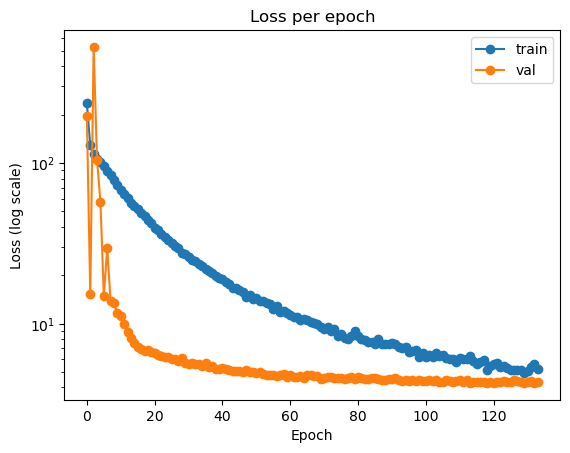

In [18]:
import matplotlib.pyplot as plt

plt.plot(clf.history['loss'], marker='o', label='train')
plt.plot(clf.history['val_rmse'], marker='o', label='val')
plt.yscale('log')  # y축을 로그 스케일로 설정
plt.title('Loss per epoch')
plt.ylabel('Loss (log scale)')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [19]:
from sklearn.metrics import mean_squared_error

preds = clf.predict(X['test'])
test_acc = np.sqrt(mean_squared_error(y_pred=preds, y_true=y['test']))
print('Test acc:', test_acc)

Test acc: 4.804902854993309


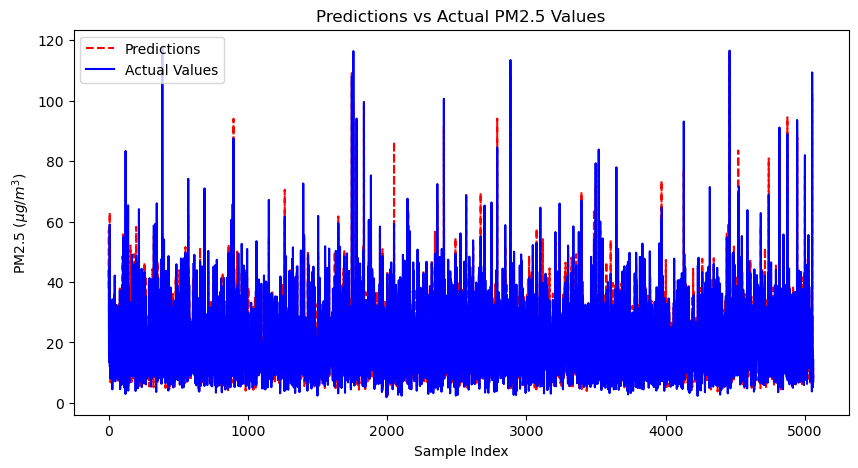

In [20]:
import matplotlib.pyplot as plt
import numpy as np

preds_cali = preds 
y_true_cali = y['test'] 

n = np.arange(len(y['test']))

# Plot predictions vs actual values
plt.figure(figsize=(10, 5))
plt.plot(n, preds_cali, label="Predictions", linestyle='dashed', color='red')
plt.plot(n, y_true_cali, label="Actual Values", linestyle='solid', color='blue')

# Labels and Title
plt.xlabel("Sample Index")
plt.ylabel(r"PM2.5 ($\mu g/m^3$)")  # LaTeX 스타일로 μg/m³ 표시
plt.title("Predictions vs Actual PM2.5 Values")
plt.legend()
plt.show()


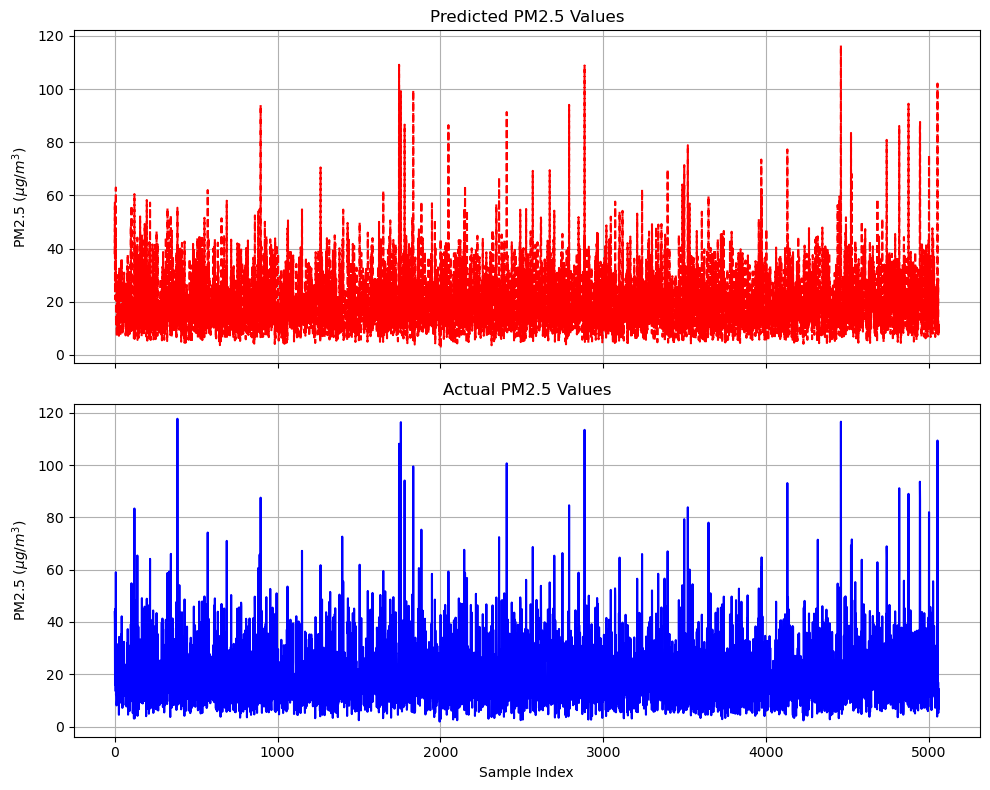

In [21]:
import matplotlib.pyplot as plt
import numpy as np

preds_cali = preds 
y_true_cali = y['test'] 

n = np.arange(len(y['test']))

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Subplot 1: Predictions
axs[0].plot(n, preds_cali, linestyle='dashed', color='red')
axs[0].set_ylabel(r"PM2.5 ($\mu g/m^3$)")
axs[0].set_title("Predicted PM2.5 Values")
axs[0].grid(True)

# Subplot 2: Actual Values
axs[1].plot(n, y_true_cali, linestyle='solid', color='blue')
axs[1].set_xlabel("Sample Index")
axs[1].set_ylabel(r"PM2.5 ($\mu g/m^3$)")
axs[1].set_title("Actual PM2.5 Values")
axs[1].grid(True)

# Layout adjustment
plt.tight_layout()
plt.show()


    Feature Name  Feature Index  Importance Score
0        t2m_tom             12          6.785329
1      pm10_ttom             31          5.098373
2       d2m_ttom             10          4.873295
3           year             33          4.871745
4       t2m_ttom             13          4.146275
5  bcaod550_ttom             19          3.350457
6        u10_tod              2          3.244270
7       u10_ttom              4          1.935016
8          month              0          1.831005
9        d2m_tod              8          1.808717


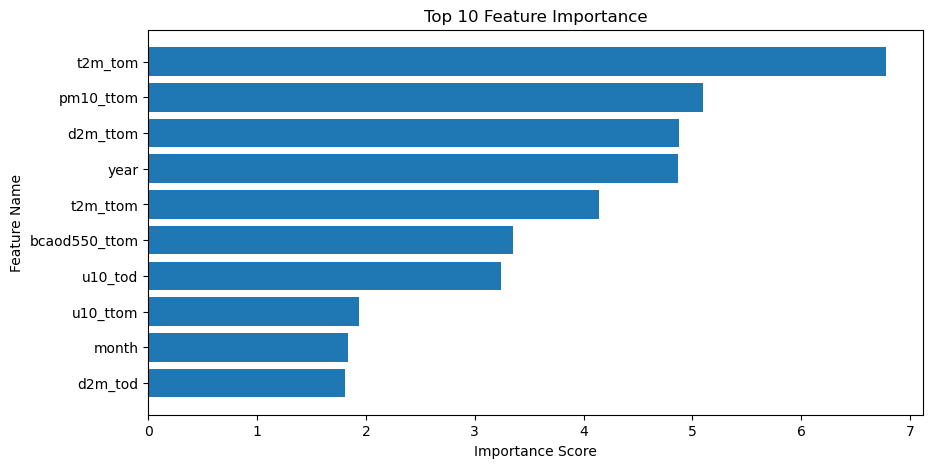

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Explain Matrix와 Mask 계산
explain_matrix, masks = clf.explain(X['test'])

# Feature Importance 계산 (전체 데이터에서 평균값)
global_feature_importance = np.mean(explain_matrix, axis=0)

# Feature Index 정렬 (중요도가 높은 순서대로)
feature_ranking = np.argsort(global_feature_importance)[::-1]  # 내림차순 정렬

# 실제 컬럼명 매칭
feature_names = np.array(data.columns)[feature_ranking]  # 중요도 순서대로 정렬

# DataFrame으로 정리
importance_df = pd.DataFrame({
    "Feature Name": feature_names,
    "Feature Index": feature_ranking,
    "Importance Score": global_feature_importance[feature_ranking]
})

# 상위 10개 Feature 출력
print(importance_df.head(10))

# Feature Importance 시각화 (상위 10개만)
plt.figure(figsize=(10, 5))
plt.barh(importance_df["Feature Name"][:10][::-1], importance_df["Importance Score"][:10][::-1])
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.title("Top 10 Feature Importance")
plt.show()


## Confusion Matrix

In [24]:
import numpy as np
from sklearn.metrics import confusion_matrix

# 이진 분류로 변환
preds_con = (preds >= 36).astype(int)
y_true_con = (y['test'] >= 36).astype(int)

# confusion matrix 계산
cm = confusion_matrix(y_true_con, preds_con)

# 결과 출력
TN, FP, FN, TP = cm.ravel()
print(f"TP: {TP}, FN: {FN}, FP: {FP}, TN: {TN}")


TP: 349, FN: 126, FP: 90, TN: 4496


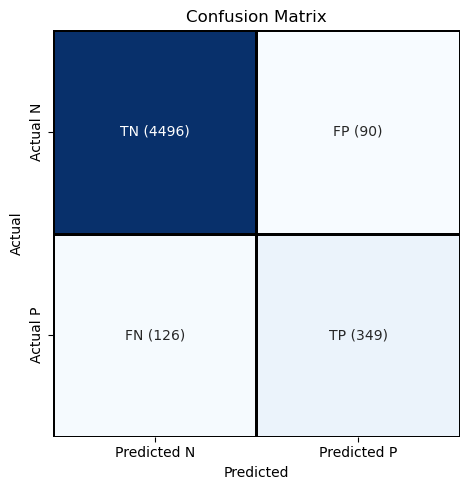

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# confusion matrix 계산
cm = confusion_matrix(y_true_con, preds_con)
labels = ['Predicted N', 'Predicted P']
categories = ['Actual N', 'Actual P']

# 비율로 변환
cm_normalized = cm / cm.sum()

# 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=[[f'TN ({cm[0][0]})', f'FP ({cm[0][1]})'], 
                                   [f'FN ({cm[1][0]})', f'TP ({cm[1][1]})']],
            fmt='', cmap='Blues', cbar=False, square=True,
            xticklabels=labels, yticklabels=categories,
            linewidths=1, linecolor='black')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()
